In [1]:
from os import system
from os.path import isfile, basename
from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

from astropy.io import fits

In [2]:
project = "Rotating_RGs"

if project == "Rotating_RGs":
    PATH = "data"
    CATALOGUE = "TIC"

    files = sorted(glob(f"{PATH}/*.npy"))

In [3]:
file = files[0]

data = np.load(file, allow_pickle=True)[()]

ID = data['ID']
Δν = data['Δν']
νmax = data['νmax']

/home/joel/.local/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


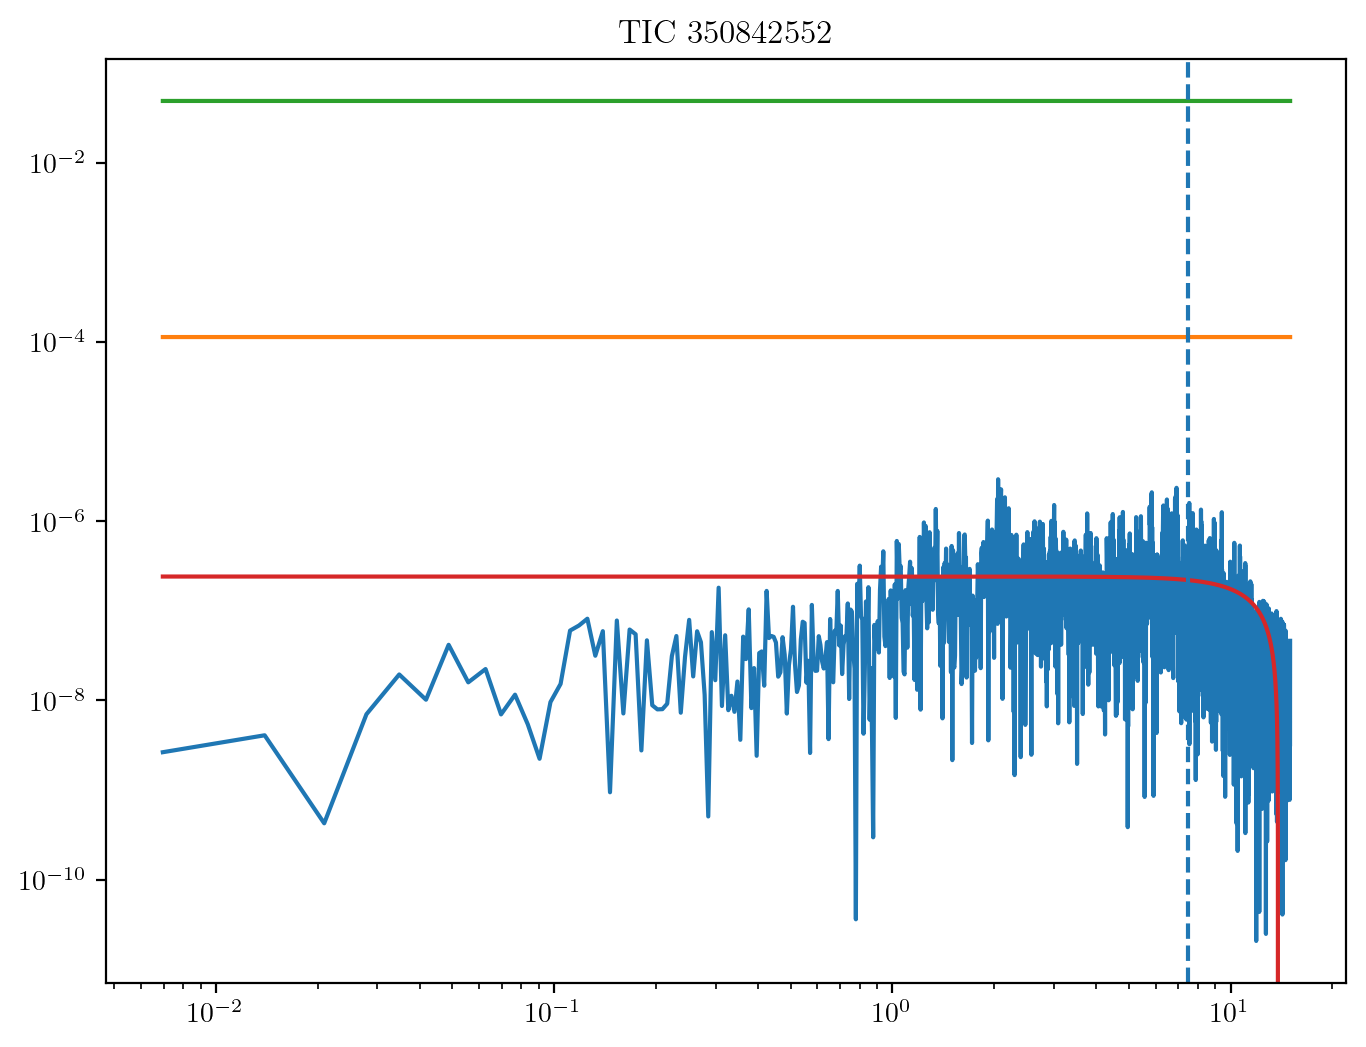

In [4]:
plt.close('all')
plt.plot(data['f'], data['p'])
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
# plt.axvline(νmax, c='red')

# def Harvey(ν, t, g):
#     return np.power(10, t) / (1 + (ν/np.power(10, g))**2)

def Harvey(ν, A, ν0):
    return 2 * np.sqrt(2) / np.pi * A**2 / (ν0 * (1 + (ν / ν0)**4))

from scipy.optimize import least_squares

def model(q):
    p = q[1:]
    return q[0] + np.sum([Harvey(data['f'], *p[2*i:2*i+2]) for i in range(len(p)//2)], axis=0)

def cost(p):
    return (data['p'] - model(p))#/np.sqrt(df.P.values)

p0 = [0, 10, 100, 10, 500]
j = least_squares(cost, p0)

for i in range(len(p0[1:])//2):
    plt.plot(data['f'], Harvey(data['p'], *j['x'][2*i+1:2*i+3]))
plt.plot(data['f'], model(j['x']))
plt.axvline(νmax, ls='dashed')
# plt.plot(df['ν'].values, model(session.bg[:-3]))
plt.title(f"{CATALOGUE} {ID}")
plt.show()

In [5]:
# from os.path import isfile
# if isfile(f"./Seed/{CATALOGUE}{ID}.pkl"):
#     seed = pd.read_pickle(f"Seed/{CATALOGUE}{ID}.pkl")
#     for _ in seed.nu_med:
#         plt.axvline(_, c='grey', ls='dotted')

%matplotlib tk


# Mode identification

In [41]:
from scipy.ndimage import gaussian_filter1d, gaussian_filter

Δν = data['Δν']
Δν = 1.21
# Δν = 47.2
# Δν = 30
# Δν = 531.8 - 519.5
νmax = data['νmax']

# Δν = 145
# νmax = 3090

ε_ν = np.mean(np.diff(data['f'])) # Grid spacing
w = int(Δν // ε_ν) # grid width in pixels
h = int(len(data['f']) // w)

Δν_plot = ε_ν * w

# cleaned = (data['p'] - model(j['x']))
cleaned = data['p']
cleaned = gaussian_filter(cleaned, .5)

f = cleaned[:w*h].reshape(h, w)
m = (data['f'] > (νmax-5*Δν))&(data['f'] < (νmax+5*Δν))

# plt.close('all')
# plt.plot(data['f'][m], data['p'][m], c='grey', alpha=.4)
# plt.plot(data['f'][m], cleaned[m])
# # plt.gca().set_yscale('log')
# plt.xlabel(r'$\nu$/$\mu$Hz')
# plt.ylabel(r'PSD/ppm$^2$ $\mu$Hz$^{-1}$')

# # from os.path import isfile
# # if isfile(f"./Seed/{CATALOGUE}{ID}.pkl"):
# #     seed = pd.read_pickle(f"Seed/{CATALOGUE}{ID}.pkl")
# #     for _ in seed.nu_med:
# #         plt.axvline(_, c='grey', ls='dotted')
# # # plt.ylim(0, 100)
# plt.show()

In [46]:
from scipy.signal import find_peaks

%matplotlib tk
plt.rcParams['text.usetex'] = False
plt.close('all')

# copy for replicated echelle diagram
ff = np.zeros_like(f)
ff[:-1] = f[1:]

plt.imshow(np.hstack((f,ff)), origin='lower', aspect=.05, cmap='rainbow', vmin=0, vmax=5e-7,
           extent=(0, 2*Δν, 0, data['f'][w*h]),
           interpolation='hanning')
plt.ylim(νmax - 10 * Δν, νmax + 10 * Δν)
plt.axhline(νmax, ls='dotted')
# plt.axvline((ε-1) * Δν)
plt.xlabel(r"$\nu$ mod $\Delta\nu/\mu$Hz")
# plt.xlabel(r"$\nu/\Delta\nu$ mod $1$")
plt.ylabel(r"$\nu/\mu$Hz")

peakfit = find_peaks(cleaned[m], height=1e-7, distance=3)
ν_trial = data['f'][m][peakfit[0]]

θ = 2 * ν_trial/Δν
ε = (θ - np.trunc(θ))/2
q = (θ/2 - ε)
l = 2 * (q - np.trunc(q))

x = ν_trial % Δν_plot
y = (ν_trial // Δν_plot + 1/2) * Δν_plot
# plt.scatter(x, y, c='grey')
# plt.scatter((ε) * Δν, ν_trial)
# plt.scatter((ε + l/2) * Δν, ν_trial)
# plt.suptitle(EPIC)
plt.suptitle(f"{CATALOGUE} {ID}")

# from astropy.io import fits
# q = fits.getdata("/home/joel/scratch/Kepler ε/subgiants/Appourchaux 2012.fits")
# q = q[q['KIC'] == ID]
# q = q[q['Com'] == 'OK']

# for l in [0, 1, 2]:
#     qq = q[q['Degree'] == l]
#     plt.plot(qq['Freq'] % Δν, qq['Freq'], 'o')

if isfile(f"./Seed/{CATALOGUE}{ID}.pkl"):
    seed = pd.read_pickle(f"Seed/{CATALOGUE}{ID}.pkl")
    for l, q in seed.groupby('ell'):
        plt.plot(q.nu_med % Δν_plot, q.nu_med, 'o', c=f'C{l}', ls='none')

if isfile(f"PBJam/{CATALOGUE} {ID}/peakbag_summary_{CATALOGUE} {ID}.csv"):
    seed = pd.read_csv(f"PBJam/{CATALOGUE} {ID}/peakbag_summary_{CATALOGUE} {ID}.csv")
    mm = [_[0] == 'l' for _ in seed['name']]
    seed = seed[mm]
    
    seed['l'] = [int(_[1]) for _ in seed['name']]
    
    for l, _ in seed.groupby('l'):
        plt.plot(_['mean'] % Δν_plot, _['mean'], '^',
                 c='blue', ls='dashed', fillstyle='none')

plt.show()

In [287]:
for Δν_inst in [47.2]:
    m_inst = abs((ν_trial + 1) % Δν_inst - 1) < .3
    x_inst = ν_trial[m_inst] % Δν_plot
    y_inst = ν_trial[m_inst]
    plt.scatter(x_inst, y_inst, marker='x', c='red')

In [40]:
# Mode identification

startx = 0
starty = 0
active_mask = np.zeros_like(ν_trial, dtype=int) - 1

which_l = 0

def ondown(event):
    global startx
    global starty
    
    startx = event.xdata
    starty = event.ydata

def onup(event):
    global startx
    global starty
    global active_mask
    global which_l
    
    endx = event.xdata
    endy = event.ydata
    
    if any([_ is None for _ in (startx, starty, endx, endy)]):
        return
    
    if startx < endx:
        mx = (x >= startx) & (x <= endx)
    else:
        mx = (x >= endx) & (x <= startx)
        
    if starty < endy:
        my = (y >= starty) & (y <= endy)
    else:
        my = (y >= endy) & (y <= starty)

    active_mask[mx & my] = which_l

    plt.scatter(x[active_mask == which_l], y[active_mask == which_l], c=f'C{which_l+1}')
    plt.show()
    
def keypress(event):
    global which_l
    global active_mask
    if event.key == 'd':
        which_l = (which_l + 1) % 3
    elif event.key == 'r':
        active_mask = active_mask * 0 - 1
        plt.scatter(x, y, c='grey')
        plt.show()
    elif event.key == 'q':
        plt.close('all')
        acc = []
        for l in [0, 1, 2]:
            mm = (active_mask == l)
            acc.append(pd.DataFrame({
                'ell': (np.ones(sum(mm)) * l).astype(int),
                'nu_med': ν_trial[mm],
                'nu_mad': ν_trial[mm],
            }))
        mode_id = pd.concat(acc).reset_index(drop=True)
        mode_id.to_pickle(f"Seed/{CATALOGUE}{ID}.pkl")
    
plt.gcf().canvas.mpl_connect('button_press_event', ondown)
plt.gcf().canvas.mpl_connect('button_release_event', onup)
plt.gcf().canvas.mpl_connect('key_press_event', keypress)

16

# Scratch

In [105]:
F = np.fft.rfft((lambda x: x - np.mean(x))(df.P.values))
Δν_trial = 1/np.fft.rfftfreq(len(df), ε_ν)
plt.plot(Δν_trial, np.abs(F)**2)
plt.xlim(0, 90)
plt.ylim(0, 4e8)
plt.axvline(Δν)
plt.show()

<ipython-input-105-6c2e7acb9637>:2: RuntimeWarning: divide by zero encountered in true_divide
  Δν_trial = 1/np.fft.rfftfreq(len(df), ε_ν)


In [106]:
ε = (np.angle(F[np.argmin((Δν_trial-Δν)**2)]) / (2 * np.pi))% 1